In [2]:
!pip install pandas networkx matplotlib torch torch_geometric scikit-learn seaborn umap-learn tensorboard optuna xgboost

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.transforms import RandomLinkSplit
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score 
from sklearn.preprocessing import MinMaxScaler
import os
from torch.utils.data import Dataset, DataLoader, random_split
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from xgboost import XGBRegressor

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Verifica se CUDA è disponibile e imposta il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


/home/kevin/Documents/uni/3anno/2_semestre/BIG DATA/graph-based-recommendation-system/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Caricamento dataset

ratings

In [2]:
ratings = pd.read_csv('../ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


generi film

In [3]:
genres = pd.read_csv('../ml-100k/u.genre', sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


dataset film con colonne one-hot per i generi

In [4]:
movies_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{row["genre"]}' for index, row in genres.iterrows()]
movies = pd.read_csv('../ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [5]:
"Ratings", ratings.columns

('Ratings',
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [6]:
"Movies", movies.columns

('Movies',
 Index(['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
        'genre_unknown', 'genre_Action', 'genre_Adventure', 'genre_Animation',
        'genre_Children's', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
        'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror',
        'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
        'genre_Thriller', 'genre_War', 'genre_Western'],
       dtype='object'))

# Preparazione vettori

## vettori utente

per ogni utente creiamo le colonne `genre_x` che contano il numero di recensioni verso quel genere

In [7]:
df_merged = pd.merge(ratings, movies, on='movieId', how='left')

genre_cols = [f'genre_{row["genre"]}' for index, row in genres.iterrows()]

df_genres_melted = df_merged.melt(id_vars=['userId', 'movieId'], value_vars=genre_cols,
                                  var_name='genre', value_name='is_genre')
df_genres_melted = df_genres_melted[df_genres_melted['is_genre'] == 1]

df_genre_counts = df_genres_melted.groupby(['userId', 'genre']).size().reset_index(name='review_count')

df_users = df_genre_counts.pivot_table(index='userId', columns='genre', values='review_count', fill_value=0)

df_users = df_users.reset_index().rename(columns={'userId': 'user_id'})

df_users.head()

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1
1,2,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0,0
2,3,14,4,0,0,12,10,1,22,0,2,5,2,11,5,8,21,5,0,0
3,4,8,4,0,0,4,4,1,6,0,0,1,1,5,3,6,11,2,0,0
4,5,56,33,14,29,82,9,0,27,2,1,28,12,3,19,33,19,14,2,1


normalizzazione

In [8]:
df_users['total_genre_reviews'] = df_users[genre_cols].sum(axis=1)

df_users_normalized = df_users[genre_cols].div(
    df_users['total_genre_reviews'], axis=0
)

df_users_normalized['user_id'] = df_users['user_id']

df_users_normalized = df_users_normalized[['user_id'] + genre_cols]

df_users_normalized.head()

genre,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208


colonna `median`: rating mediano espresso

In [9]:
user_medians = ratings.groupby('userId')['rating'].median().reset_index()
user_medians = user_medians.rename(columns={'userId': 'user_id', 'rating': 'median'})
df_users_normalized = df_users_normalized.merge(user_medians, on='user_id', how='left')

df_users_normalized.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,4.0
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,3.0
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,5.0
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208,3.0


raffinamento pesi `genre_x`

In [10]:
global_genre_avg = df_users_normalized[genre_cols].mean()
df_relative_fan_score = df_users_normalized[genre_cols].div(global_genre_avg, axis=1).fillna(0)

scaler = MinMaxScaler()
df_normalized_weighted = pd.DataFrame(
    scaler.fit_transform(df_relative_fan_score),
    index=df_relative_fan_score.index,
    columns=df_relative_fan_score.columns
)

df_normalized_weighted['total'] = df_normalized_weighted[genre_cols].sum(axis=1)
df_normalized_weighted = df_normalized_weighted[genre_cols].div(
    df_normalized_weighted['total'], axis=0
)
df_normalized_weighted['user_id'] = df_users_normalized['user_id']
df_normalized_weighted['median'] = df_users_normalized['median']

print("Before fan score normalization:")
display(df_users_normalized.head(1))
print("After fan score normalization:")
display(df_normalized_weighted.head(1))
print("Mean genre scores")
pd.DataFrame(df_users_normalized[genre_cols].mean())

Before fan score normalization:


,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.07155,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0


After fan score normalization:


,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,user_id,median
0,0.023031,0.096989,0.091916,0.029128,0.037343,0.08861,0.079028,0.03895,0.08131,0.019418,0.007075,0.015264,0.056097,0.015523,0.039967,0.087383,0.064322,0.066327,0.062319,1,4.0


Mean genre scores


,0
genre_unknown,0.000041
genre_Action,0.117094
genre_Adventure,0.058277
genre_Animation,0.014013
genre_Children's,0.028909
genre_Comedy,0.130530
genre_Crime,0.040604
genre_Documentary,0.003371
genre_Drama,0.198023
genre_Fantasy,0.004923


## vettore film

rimozione colonne inutili

In [11]:
df_movies = movies[['movieId'] + genre_cols].rename(columns={'movieId': 'movie_id'})
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


aggiunta colonna mediana dei rating verso quel film

In [ ]:
movie_medians = ratings.groupby('movieId')['rating'].median().reset_index()
movie_medians = movie_medians.rename(columns={'movieId': 'movie_id', 'rating': 'median'})

df_movies = df_movies.merge(movie_medians, on='movie_id', how='left')
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3.0


# Creazione grafo

In [13]:
B = nx.Graph()

nodi users

In [14]:
B.add_nodes_from(
    [
        (
            f"user_{uid}",
            {
                **{col: df_normalized_weighted.loc[df_normalized_weighted['user_id'] == uid, col].values[0] for col in df_normalized_weighted.columns if col != 'user_id'},
                'user_id': uid
            }
        )
        for uid in df_normalized_weighted['user_id']
    ],
    bipartite=0
)
print(f"Aggiunti {len(df_normalized_weighted)} nodi utente.")

Aggiunti 943 nodi utente.


In [15]:
print("Users node")
B.nodes['user_1']

Users node


{'bipartite': 0,
 'genre_unknown': 0.02303105548593626,
 'genre_Action': 0.09698907056243211,
 'genre_Adventure': 0.09191579610224337,
 'genre_Animation': 0.029127511349860562,
 "genre_Children's": 0.03734296326905202,
 'genre_Comedy': 0.08861029252217759,
 'genre_Crime': 0.07902813156938915,
 'genre_Documentary': 0.0389495791306275,
 'genre_Drama': 0.08130973332804814,
 'genre_Fantasy': 0.01941834089990704,
 'genre_Film-Noir': 0.0070748993976405515,
 'genre_Horror': 0.015263719125973444,
 'genre_Musical': 0.05609742926639812,
 'genre_Mystery': 0.015523382986844294,
 'genre_Romance': 0.03996702540596214,
 'genre_Sci-Fi': 0.08738253404958173,
 'genre_Thriller': 0.06432202708604193,
 'genre_War': 0.06632718185288017,
 'genre_Western': 0.062319326609003994,
 'median': 4.0,
 'user_id': 1}

nodi film

In [16]:
B.add_nodes_from(
    [
        (
            f"movie_{mid}",
            {
                'movie_id': mid,
                **{col: df_movies.loc[df_movies['movie_id'] == mid, col].values[0] for col in df_movies.columns if col != 'movie_id'}
            }
        )
        for mid in df_movies['movie_id']
    ],
    bipartite=1
)
print(f"Aggiunti {len(df_movies)} nodi film.")

Aggiunti 1682 nodi film.


In [17]:
print("Movies node")
B.nodes['movie_1']

Movies node


{'bipartite': 1,
 'movie_id': 1,
 'genre_unknown': 0,
 'genre_Action': 0,
 'genre_Adventure': 0,
 'genre_Animation': 1,
 "genre_Children's": 1,
 'genre_Comedy': 1,
 'genre_Crime': 0,
 'genre_Documentary': 0,
 'genre_Drama': 0,
 'genre_Fantasy': 0,
 'genre_Film-Noir': 0,
 'genre_Horror': 0,
 'genre_Musical': 0,
 'genre_Mystery': 0,
 'genre_Romance': 0,
 'genre_Sci-Fi': 0,
 'genre_Thriller': 0,
 'genre_War': 0,
 'genre_Western': 0,
 'median': 4.0}

In [18]:
for index, row in ratings.iterrows():
    user_node = f"user_{row['userId']}"
    movie_node = f"movie_{row['movieId']}"
    
    rating_value = row['rating']
    timestamp_value = row['timestamp']
    
    B.add_edge(user_node, movie_node, rating=rating_value, timestamp=timestamp_value)

print(f"\nGrafo Bipartito creato con successo!")
print(f"Numero totale di nodi nel grafo: {B.number_of_nodes()}")
print(f"Numero totale di archi nel grafo: {B.number_of_edges()}")


Grafo Bipartito creato con successo!
Numero totale di nodi nel grafo: 2625
Numero totale di archi nel grafo: 100000


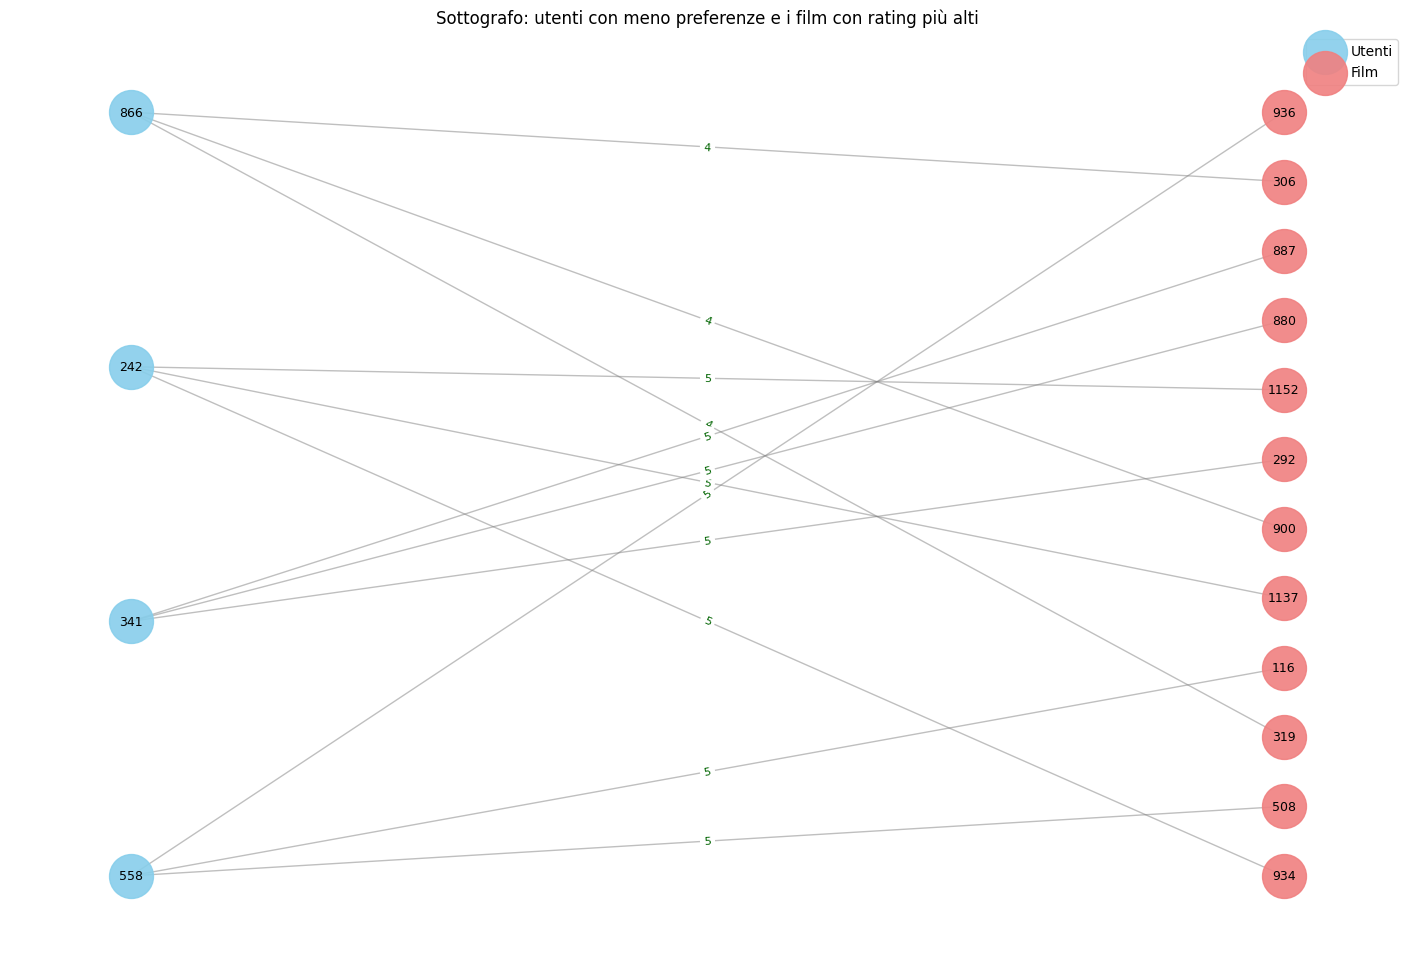

In [19]:
users_count = 4
max_movies_per_user = 3

user_genre_sums = df_users[genre_cols].sum(axis=1)
sorted_users = df_users.loc[user_genre_sums.nsmallest(users_count).index]
min_user_ids = sorted_users['user_id'].tolist()

selected_user_nodes = [f"user_{uid}" for uid in min_user_ids if f"user_{uid}" in B.nodes]

selected_movie_nodes = set()
user_movie_edges = []

for u_node in selected_user_nodes:
    if u_node not in B.nodes:
        continue

    neighbors = list(B.neighbors(u_node))


    neighbors_sorted = sorted(
        neighbors,
        key=lambda n: B.edges[u_node, n].get('rating', 0),
        reverse=True
    )


    limited_neighbors = neighbors_sorted[:max_movies_per_user]

    for m_node in limited_neighbors:
        selected_movie_nodes.add(m_node)
        user_movie_edges.append((u_node, m_node))

B_sub = nx.Graph()

for u_node in selected_user_nodes:
    B_sub.add_node(u_node, **B.nodes[u_node])

for m_node in selected_movie_nodes:
    B_sub.add_node(m_node, **B.nodes[m_node])

for u_node, m_node in user_movie_edges:
    if B.has_edge(u_node, m_node):
        B_sub.add_edge(u_node, m_node, **B.edges[u_node, m_node])


plt.figure(figsize=(18, 12))

user_nodes_sub = {n for n in selected_user_nodes if n in B_sub.nodes()}
pos_sub = nx.bipartite_layout(B_sub, user_nodes_sub)

nx.draw_networkx_nodes(
    B_sub, pos_sub,
    nodelist=list(user_nodes_sub),
    node_color='skyblue',
    node_size=1000,
    label='Utenti',
    alpha=0.9
)

nx.draw_networkx_nodes(
    B_sub, pos_sub,
    nodelist=list(selected_movie_nodes),
    node_color='lightcoral',
    node_size=1000,
    label='Film',
    alpha=0.9
)

nx.draw_networkx_edges(B_sub, pos_sub, width=1.0, alpha=0.5, edge_color='gray')

labels = {}
for node, data in B_sub.nodes(data=True):
    if data.get('bipartite') == 0:
        labels[node] = node.replace('user_', '')
    elif data.get('bipartite') == 1:
        labels[node] = data.get('movie_id', node.replace('movie_', ''))
nx.draw_networkx_labels(B_sub, pos_sub, labels, font_size=9, font_color='black')

edge_labels = nx.get_edge_attributes(B_sub, 'rating')
nx.draw_networkx_edge_labels(B_sub, pos_sub, edge_labels=edge_labels, font_size=8, font_color='darkgreen')

plt.legend(scatterpoints=1)
plt.axis('off')
plt.title("Sottografo: utenti con meno preferenze e i film con rating più alti")
plt.show()

# GrapSAGE

## Setup

conversione in pytorch geometric

In [22]:
# Mapping dei nodi
node_to_idx = {node: i for i, node in enumerate(B.nodes())}
idx_to_node = {i: node for node, i in node_to_idx.items()}
num_nodes = B.number_of_nodes()

user_keys = None
item_keys = None

for node in B.nodes():
    data = B.nodes[node]
    if data['bipartite'] == 0 and user_keys is None:
        user_keys = [k for k in data if k not in ('bipartite', 'user_id')]
    elif data['bipartite'] == 1 and item_keys is None:
        item_keys = [k for k in data if k not in ('bipartite', 'movie_id')]
    if user_keys and item_keys:
        break

# Costruisci le feature dinamicamente
features = []
for node in B.nodes():
    data = B.nodes[node]
    keys = user_keys if data['bipartite'] == 0 else item_keys
    feat = [float(data.get(k, 0.0)) for k in keys]  # fallback a 0.0 se mancante
    features.append(torch.tensor(feat, dtype=torch.float))


x = torch.stack(features)

edge_index_list = []
for u, v in B.edges():
    edge_index_list.append([node_to_idx[u], node_to_idx[v]])
    edge_index_list.append([node_to_idx[v], node_to_idx[u]])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
edge_index = edge_index.to(device)


print(f"Numero totale di nodi: {num_nodes}")
print(f"Numero totale di archi (bidirezionali): {edge_index.size(1)}")

# Stampa info
user_count = sum(1 for node in B.nodes if B.nodes[node]['bipartite'] == 0)
item_count = num_nodes - user_count
print(f"Nodi utente: {user_count}, Nodi item (film): {item_count}")

# Stampa un solo nodo utente
user_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 0)
user_idx = node_to_idx[user_node]
print("\nNodo utente:")
print(f" Nodo: {user_node}")
print(f" Feature: {x[user_idx].cpu().numpy()}")

# Stampa un solo nodo item (film)
item_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 1)
item_idx = node_to_idx[item_node]
print("\nNodo film:")
print(f" Nodo: {item_node}")
print(f" Feature: {x[item_idx].cpu().numpy()}")

Numero totale di nodi: 2625
Numero totale di archi (bidirezionali): 200000
Nodi utente: 943, Nodi item (film): 1682

Nodo utente:
 Nodo: user_1
 Feature: [0.02303106 0.09698907 0.09191579 0.02912751 0.03734296 0.08861029
 0.07902813 0.03894958 0.08130974 0.01941834 0.0070749  0.01526372
 0.05609743 0.01552338 0.03996703 0.08738253 0.06432202 0.06632718
 0.06231933 4.        ]

Nodo film:
 Nodo: movie_1
 Feature: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]


split dataset in train e test

In [ ]:
network = Data(x=x, edge_index=edge_index)

transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    num_val=0.2,
    num_test=0.1,
    split_labels=True
)

train_data, val_data, test_data = transform(network)

print("Train Data:\n", train_data)
print("\nValidation Data:\n", val_data)
print("\nTest Data:\n", test_data)

Train Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[70000], pos_edge_label_index=[2, 70000], neg_edge_label=[70000], neg_edge_label_index=[2, 70000])

Validation Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[20000], pos_edge_label_index=[2, 20000], neg_edge_label=[20000], neg_edge_label_index=[2, 20000])

Test Data:
 Data(x=[2625, 20], edge_index=[2, 180000], pos_edge_label=[10000], pos_edge_label_index=[2, 10000], neg_edge_label=[10000], neg_edge_label_index=[2, 10000])


## Link prediction

In [24]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        
        # Primo layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        # Layer intermedi
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Ultimo layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        return x

In [25]:
def get_scores(scores, labels):
    auc = roc_auc_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())
    ap = average_precision_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())

    return {
        'accuracy': auc,
        'precision': ap
    }

def process(model, data):
    node_embeddings = model(data.x, data.edge_index)
    
    pos_edge_embedding = node_embeddings[data.pos_edge_label_index[0]] * node_embeddings[data.pos_edge_label_index[1]]
    neg_edge_embedding = node_embeddings[data.neg_edge_label_index[0]] * node_embeddings[data.neg_edge_label_index[1]]

    pos_scores = pos_edge_embedding.sum(dim=1)
    neg_scores = neg_edge_embedding.sum(dim=1)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    loss = F.binary_cross_entropy_with_logits(scores, labels)

    return loss, scores, labels

def train(model, optimizer):
    model.train()
    optimizer.zero_grad()

    loss, scores, labels = process(model, train_data)

    loss.backward()

    found_gradients = False
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-9: 
                found_gradients = True

    optimizer.step()

    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

@torch.no_grad() 
def test(model, data):
    model.eval() 
    
    loss, scores, labels = process(model, data)
    
    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

In [49]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128, step=16)
    out_channels = trial.suggest_int('out_channels', 16, 128, step=16)
    num_layers      = trial.suggest_int('num_layers', 1, 5)
    dropout         = trial.suggest_float('dropout', 0.0, 0.8)
    lr = 0.001

    model = GraphSAGE(
        in_channels=network.x.size(1),
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    exp = '12'
    name = f'exp_{exp}-{num_layers}_layers-{hidden_channels}_inSize-{out_channels}_outSize-{dropout}_dropout-lr_{lr}'
    writer = SummaryWriter(f'../runs/{name}')
    print(f""
      f"num_layers={num_layers}, "
      f"hidden_channels={hidden_channels}, "
      f"out_channels={out_channels}, "
      f"dropout={dropout:.2f}, "
      f"learning_rate={lr:.1e}")

    best_acc = 0.0
    epochs   = 500

    for epoch in range(1, epochs + 1):
        train_res = train(model, optimizer)
        val_res  = test(model, val_data)

        trial.report(val_res['scores']['accuracy'], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        combined_score = 0.5 * val_res['scores']['accuracy'] + 0.5 * val_res['scores']['precision']
        best_acc = max(best_acc, combined_score)

        if epoch == 1 or epoch % 10 == 0:
            writer.add_scalar('loss/train', train_res['loss'], epoch)
            writer.add_scalar('auc/train',  train_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/train',   train_res['scores']['precision'], epoch)
            writer.add_scalar('loss/test',  val_res['loss'], epoch)
            writer.add_scalar('auc/test',   val_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/test',    val_res['scores']['precision'], epoch)
            
    print(f"Epoch {epoch:03d} | "
            f"lr={lr:.1e} hid={hidden_channels} lay={num_layers} drop={dropout:.2f} | "
            f"Train Acc={train_res['scores']['accuracy']:.4f} "
            f"Test Acc={val_res['scores']['accuracy']:.4f}\n\n")

    torch.save(model.state_dict(), f'../weights/{name}.pth')

    return best_acc

In [50]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner(min_resource=50)
)
study.optimize(objective, n_trials=10, timeout=3600)

print("Best accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2025-07-06 18:17:42,983] A new study created in memory with name: no-name-e4dc7eec-d97d-49e8-bf74-afa74f1b4270


num_layers=2, hidden_channels=16, out_channels=112, dropout=0.42, learning_rate=1.0e-03


[I 2025-07-06 18:21:27,367] Trial 0 finished with value: 0.7551948812956737 and parameters: {'hidden_channels': 16, 'out_channels': 112, 'num_layers': 2, 'dropout': 0.41958975221212297}. Best is trial 0 with value: 0.7551948812956737.


Epoch 500 | lr=1.0e-03 hid=16 lay=2 drop=0.42 | Train Acc=0.7301 Test Acc=0.7767


num_layers=4, hidden_channels=64, out_channels=16, dropout=0.00, learning_rate=1.0e-03


[I 2025-07-06 18:24:20,842] Trial 1 finished with value: 0.8485165778512589 and parameters: {'hidden_channels': 64, 'out_channels': 16, 'num_layers': 4, 'dropout': 4.806245110247076e-05}. Best is trial 1 with value: 0.8485165778512589.


Epoch 500 | lr=1.0e-03 hid=64 lay=4 drop=0.00 | Train Acc=0.8680 Test Acc=0.8549


num_layers=5, hidden_channels=48, out_channels=64, dropout=0.42, learning_rate=1.0e-03


[I 2025-07-06 18:24:46,055] Trial 2 pruned. 


num_layers=2, hidden_channels=32, out_channels=32, dropout=0.14, learning_rate=1.0e-03


[I 2025-07-06 18:24:59,655] Trial 3 pruned. 


num_layers=2, hidden_channels=48, out_channels=112, dropout=0.24, learning_rate=1.0e-03


[I 2025-07-06 18:25:25,177] Trial 4 pruned. 


num_layers=2, hidden_channels=64, out_channels=64, dropout=0.41, learning_rate=1.0e-03


[I 2025-07-06 18:25:45,969] Trial 5 pruned. 


num_layers=4, hidden_channels=128, out_channels=96, dropout=0.59, learning_rate=1.0e-03


[I 2025-07-06 18:26:25,917] Trial 6 pruned. 


num_layers=4, hidden_channels=64, out_channels=96, dropout=0.45, learning_rate=1.0e-03


[I 2025-07-06 18:26:55,721] Trial 7 pruned. 


num_layers=4, hidden_channels=16, out_channels=48, dropout=0.10, learning_rate=1.0e-03


[I 2025-07-06 18:27:58,987] Trial 8 pruned. 


num_layers=2, hidden_channels=96, out_channels=64, dropout=0.39, learning_rate=1.0e-03


[I 2025-07-06 18:28:14,664] Trial 9 pruned. 


Best accuracy: 0.8485165778512589
Best params: {'hidden_channels': 64, 'out_channels': 16, 'num_layers': 4, 'dropout': 4.806245110247076e-05}


In [86]:
best_graphsage_params = study.best_params
best_graphsage_params['lr'] = 0.001
best_graphsage_params

{'hidden_channels': 64,
 'out_channels': 16,
 'num_layers': 4,
 'dropout': 4.806245110247076e-05,
 'lr': 0.001}

In [180]:
# exp1
# best_graphsage_params = {
#     'hidden_channels': 128,
#     'out_channels': 32,
#     'num_layers': 5,
#     'dropout': 0.038231541786975076,
#     'lr': 0.001,
#     'exp': '1'
# }

# exp2
best_graphsage_params = {
    'hidden_channels': 64,
    'out_channels': 16,
    'num_layers': 4,
    'dropout': 4.806245110247076e-05,
    'lr': 0.001,
    'exp': '2'
}


In [181]:
model = GraphSAGE(
    in_channels=network.x.size(1),
    hidden_channels=best_graphsage_params['hidden_channels'],
    out_channels=best_graphsage_params['out_channels'],
    num_layers=best_graphsage_params['num_layers'],
    dropout=best_graphsage_params['dropout'],
)

weights = f"exp_12-{best_graphsage_params['num_layers']}_layers-{best_graphsage_params['hidden_channels']}_inSize-{best_graphsage_params['out_channels']}_outSize-{best_graphsage_params['dropout']}_dropout-lr_{best_graphsage_params['lr']}.pth"
model.load_state_dict(torch.load(f'../weights/{weights}'))
model.eval()
print(f"Caricato i pesi {weights}")

Caricato i pesi exp_12-4_layers-64_inSize-16_outSize-4.806245110247076e-05_dropout-lr_0.001.pth


/tmp/ipykernel_4055/2107459765.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/{weights}'))


In [182]:
f'EXP_{best_graphsage_params["exp"]}', test(model, test_data)

('EXP_2',
 {'loss': 0.5540428757667542,
  'scores': {'accuracy': 0.8615259, 'precision': 0.8475858622250743}})

## Rating regressor

### Pytorch

In [46]:
with torch.no_grad():
    node_embeddings = model(network.x, network.edge_index)

In [159]:
class RatingDataset(Dataset):
    def __init__(self, ratings_df, node_emb):
        self.user_ids = torch.tensor(ratings_df['userId'].values, dtype=torch.long)
        self.movie_ids = torch.tensor(ratings_df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings_df['rating'].values, dtype=torch.float32)
        self.embeddings = node_emb  # full embedding matrix

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user_emb = self.embeddings[self.user_ids[idx]]
        movie_emb = self.embeddings[self.movie_ids[idx]]
        x = torch.cat([user_emb, movie_emb], dim=0)  # input vector
        y = self.ratings[idx]
        return x, y

In [160]:
dataset = RatingDataset(ratings, node_embeddings)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [32]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, num_hidden: int, hidden_dim: int, dropout: float = 0.2):
        super().__init__()
        layers = []
        
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(hidden_dim, 1))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        rating = self.net(x).squeeze()
        return rating

In [33]:
def evaluate(model, loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(y)
    return np.sqrt(total_loss / len(loader.dataset))

In [103]:
def objective(trial):
    num_hidden = trial.suggest_int('num_hidden', 1, 5)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
    dropout = trial.suggest_float('dropout', 0.0, 0.8)
    lr = 0.001

    mlp_model = MLP(
        input_dim=best_graphsage_params['out_channels']*2,
        num_hidden=num_hidden,
        hidden_dim=hidden_dim,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    name = f'REGRESSOR-exp_1-{num_hidden}_layers-{hidden_dim}_hiddenSize-{dropout:.2f}_dropout-lr_{lr}'
    writer = SummaryWriter(f'../runs/{name}')

    print(f"num_hidden={num_hidden}, hidden_dim={hidden_dim}, dropout={dropout:.2f}, learning_rate={lr:.1e}")

    best_rmse = float('inf')
    epochs = 50

    for epoch in range(1, epochs + 1):
        epoch_losses = {'train': 0.0, 'val': 0.0}
        epoch_sizes = {'train': 0, 'val': 0}
        epoch_rmses = {'train': 0.0, 'val': 0.0}

        for mode in ['train', 'val']:
            if mode == 'train':
                mlp_model.train()
                loader = train_loader
            else:
                mlp_model.eval()
                loader = val_loader

            for x, y in loader:
                if mode == 'train':
                    optimizer.zero_grad()
                    preds = mlp_model(x)
                    loss = criterion(preds, y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = mlp_model(x)
                        loss = criterion(preds, y)

                epoch_losses[mode] += loss.item() * len(y)
                epoch_sizes[mode] += len(y)

        for mode in ['train', 'val']:
            avg_loss = epoch_losses[mode] / epoch_sizes[mode]
            rmse = np.sqrt(avg_loss)
            epoch_rmses[mode] = rmse

            writer.add_scalar(f'Loss/{mode}', avg_loss, epoch)
            writer.add_scalar(f'RMSE/{mode}', rmse, epoch)

        trial.report(epoch_rmses['val'], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Salvataggio modello migliore
        if epoch_rmses['val'] < best_rmse:
            best_rmse = epoch_rmses['val']
            torch.save(mlp_model.state_dict(), f'../weights/{name}.pth')

    print(f"\nBest Val RMSE: {best_rmse:.4f} — Model saved as {name}.pth\n")
    return best_rmse

In [ ]:
mlp_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner(min_resource=5)
)

mlp_study.optimize(objective, n_trials=10, timeout=3600)

print("Best RMSE:", mlp_study.best_value)
print("Best params:", mlp_study.best_params)

In [ ]:
mlp_best_params = mlp_study.best_params
mlp_best_params['lr'] = 0.001
mlp_best_params['exp'] = '1'
mlp_best_params

In [31]:
mlp_best_params = {
    'num_hidden': 4,
    'hidden_channels': 80,
    'dropout': 0.05,
    'lr': 0.001,
    'exp': '0'
}
mlp_best_params

{'num_hidden': 4,
 'hidden_channels': 80,
 'dropout': 0.05,
 'lr': 0.001,
 'exp': '0'}

In [61]:
mlp_model = MLP(
    input_dim=best_graphsage_params['out_channels']*2,
    num_hidden=mlp_best_params['num_hidden'],
    hidden_dim=mlp_best_params['hidden_channels'],
    dropout=mlp_best_params['dropout']
)

weights = f'REGRESSOR-exp_{mlp_best_params["exp"]}-{mlp_best_params["num_hidden"]}_layers-{mlp_best_params["hidden_channels"]}_hiddenSize-{mlp_best_params["dropout"]:.2f}_dropout-lr_{mlp_best_params["lr"]}.pth'
mlp_model.load_state_dict(torch.load(f'../weights/{weights}'))
mlp_model.eval()
print(f"Caricato i pesi {weights}")

test_rmse = evaluate(mlp_model, test_loader)
print(f"\nTest RMSE: {test_rmse:.4f}")

Caricato i pesi REGRESSOR_EN-exp_0-4_layers-80_hiddenSize-0.05_dropout-lr_0.001.pth

Test RMSE: 1.0081


### XGBOOST

In [149]:
user_ids = torch.tensor(ratings['userId'].values, dtype=torch.long)
movie_ids = torch.tensor(ratings['movieId'].values, dtype=torch.long)
ratings_vals = ratings['rating'].values.astype(np.float32)

user_embs = node_embeddings[user_ids]
movie_embs = node_embeddings[movie_ids]

X_tensor = torch.cat([user_embs, movie_embs], dim=1)
X = X_tensor.numpy()
y = ratings_vals

In [150]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [70]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }

    model = XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    val_preds = model.predict(X_val)
    val_rmse = np.sqrt(np.mean( (y_val - val_preds) ** 2 ))
    return val_rmse

study = optuna.create_study(study_name='XGBOOST regressione',direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-07-09 00:37:50,699] A new study created in memory with name: XGBOOST regressione
[I 2025-07-09 00:37:53,287] Trial 0 finished with value: 1.0723813772201538 and parameters: {'n_estimators': 130, 'max_depth': 4, 'learning_rate': 0.027987368724796714}. Best is trial 0 with value: 1.0723813772201538.
[I 2025-07-09 00:37:57,129] Trial 1 finished with value: 1.0069172382354736 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.06266264529278075}. Best is trial 1 with value: 1.0069172382354736.
[I 2025-07-09 00:38:03,462] Trial 2 finished with value: 0.9721499085426331 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.12080508050048054}. Best is trial 2 with value: 0.9721499085426331.
[I 2025-07-09 00:38:05,343] Trial 3 finished with value: 1.099656343460083 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.011934434273264726}. Best is trial 2 with value: 0.9721499085426331.
[I 2025-07-09 00:38:07,092] Trial 4 finish

In [71]:
print("Migliori parametri:", study.best_params)
print(f"Miglior RMSE sulla validation: {study.best_value:.4f}")

Migliori parametri: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.2858812760979694}
Miglior RMSE sulla validation: 0.9655


In [72]:
best_params = study.best_params
best_params.update({'random_state': 42, 'objective': 'reg:squarederror'})
xgbmodel = XGBRegressor(**best_params)
xgbmodel.fit(X_train, y_train)

test_preds = xgbmodel.predict(X_test)
test_rmse = np.sqrt(np.mean( (y_test - test_preds) ** 2 ))

print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.9574


# Ulteriori valutazioni

## Similarità film - film

In [183]:
with torch.no_grad():
    node_embeddings = model(network.x, network.edge_index)


def get_node_id_field(node_id):
    """
    Recupera il campo ID specifico (user_id o movie_id) per un nodo dal grafo NetworkX B.
    """
    node_attrs = B.nodes[node_id]
    if node_attrs['bipartite'] == 0: # È un utente
        return node_attrs.get('user_id', node_id)
    else: # È un film (o item)
        return node_attrs.get('movie_id', node_id)

In [115]:
def get_films_from(film_id):
    start_movie_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 1 and attrs['movie_id'] == film_id)
    start_movie_idx = node_to_idx[start_movie_original_id]
    start_movie_embedding = node_embeddings[start_movie_idx].unsqueeze(0)
    
    candidate_similar_movie_ids = [
        node_id for node_id, attrs in B.nodes(data=True)
        if attrs['bipartite'] == 1 and node_id != start_movie_original_id
    ]

    if not candidate_similar_movie_ids:
        print(f"Non ci sono altri film nel grafo simili a '{get_node_id_field(start_movie_original_id)}'.")
    else:
        candidate_similar_movie_indices = [node_to_idx[oid] for oid in candidate_similar_movie_ids]
        candidate_similar_movie_embeddings = node_embeddings[candidate_similar_movie_indices]  # shape: [N, dim]

        similarities = F.cosine_similarity(start_movie_embedding, candidate_similar_movie_embeddings, dim=1)

        top_k = min(5, similarities.size(0))
        top_k_indices = torch.topk(similarities, top_k).indices

        top_k_similar_movie_ids = [candidate_similar_movie_ids[i] for i in top_k_indices.tolist()]

        return [int(movie_id.split('_')[1]) for movie_id in top_k_similar_movie_ids]

In [137]:
film_id = 50
sim_film = get_films_from(film_id)

title = movies[movies['movieId'] == film_id]['title'].values[0]
print("Film partenza\n", title)

print("")

print("Primi 5 simili")
for title in movies[movies['movieId'].isin(sim_film)]['title']:
    print(title)

Film partenza
 Star Wars (1977)

Primi 5 simili
Independence Day (ID4) (1996)
Aliens (1986)
Return of the Jedi (1983)
Menace II Society (1993)
City of Lost Children, The (1995)


## t-SNE

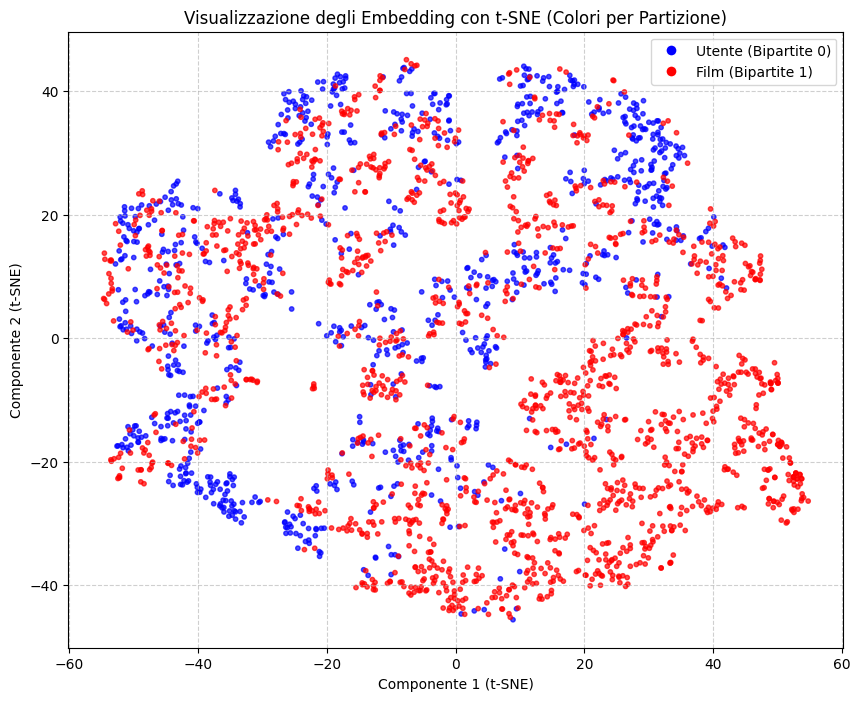

In [184]:
embeddings_np = node_embeddings.cpu().numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)


embeddings_2d_tsne = tsne.fit_transform(embeddings_np)

try:
    colors = []
    for i in range(len(embeddings_np)):
        original_node_id = idx_to_node[i]
        node_type = B.nodes[original_node_id]['bipartite']
        colors.append('blue' if node_type == 0 else 'red')

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], 
                          c=colors, s=10, alpha=0.7)
    plt.title('Visualizzazione degli Embedding con t-SNE (Colori per Partizione)')
    plt.xlabel('Componente 1 (t-SNE)')
    plt.ylabel('Componente 2 (t-SNE)')
    plt.grid(True, linestyle='--', alpha=0.6)

    handles = [plt.Line2D([0], [0], marker='o', color='w', label='Utente (Bipartite 0)', 
                          markerfacecolor='blue', markersize=8),
               plt.Line2D([0], [0], marker='o', color='w', label='Film (Bipartite 1)', 
                          markerfacecolor='red', markersize=8)]
    plt.legend(handles=handles)
    plt.show()

except NameError:
    print("\nPer plottare con colori per partizione, assicurati che 'B' e 'idx_to_node' siano definiti.")
except Exception as e:
    print(f"\nErrore durante il plotting con colori per partizione (t-SNE): {e}")